# 12 Monsters and Mixtures

## Imports, loadings and functions

In [1]:
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import pandas as pd

import networkx as nx
# from causalgraphicalmodels import CausalGraphicalModel

import arviz as az
# ArviZ ships with style sheets!
# https://python.arviz.org/en/stable/examples/styles.html#example-styles
az.style.use("arviz-darkgrid")

import xarray as xr

import stan
import nest_asyncio

plt.style.use('default')
plt.rcParams['axes.facecolor'] = 'lightgray'

# To DAG's
import daft
from causalgraphicalmodels import CausalGraphicalModel

In [2]:
# Add fonts to matplotlib to run xkcd

from matplotlib import font_manager

font_dirs = ["fonts/"]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [3]:
# To make plots like drawing 
plt.xkcd()

In [4]:
# To running the stan in jupyter notebook
nest_asyncio.apply()

In [5]:
# Utils functions

def logit(p):
    return np.log(p) - np.log(1 - p)

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

## 12.1 Over-dispersed counts

### 12.1.1 Beta-Binomial

Beta distributuion:

$$ x \sim beta(\bar{p}, \theta) $$


another parametrization:

$$ x \sim beta(\alpha, \beta) $$

where:
$$ \alpha = \bar{p} \theta $$

$$ \beta = (1 - \bar{p}) \theta$$

### R Code 12.1

In [6]:
def plot_beta(p_bar, theta):
    alpha = p_bar * theta  # Alpha = p * theta
    beta = (1 - p_bar) * theta  # beta = (1-p) * theta

    x = np.linspace(0, 1, num=100)

    plt.figure(figsize=(17, 5))

    plt.plot(x, stats.beta.pdf(x, alpha, beta))

    plt.title(f'Beta Distribution \n\n $alpha={round(alpha, 3)}$, $beta={round(beta, 3)}$ \n\n $pbar={p_bar}$, $theta={theta}$')
    plt.ylabel('Density')
    plt.xlabel('x')
    plt.show()

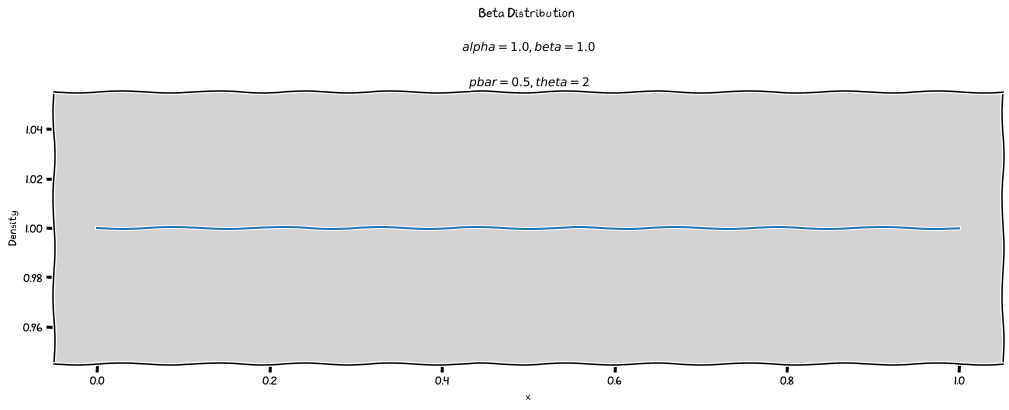

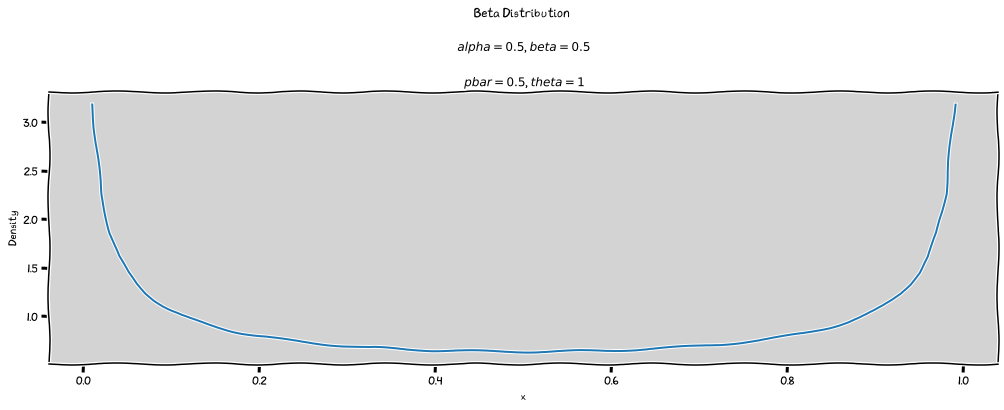

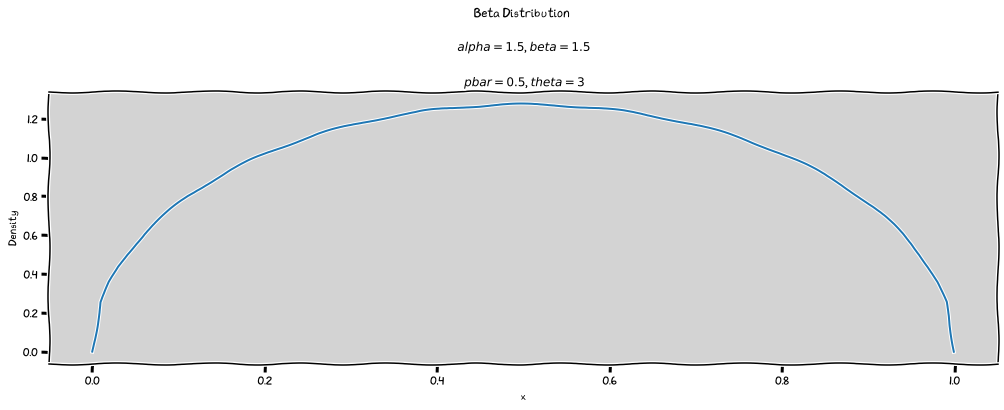

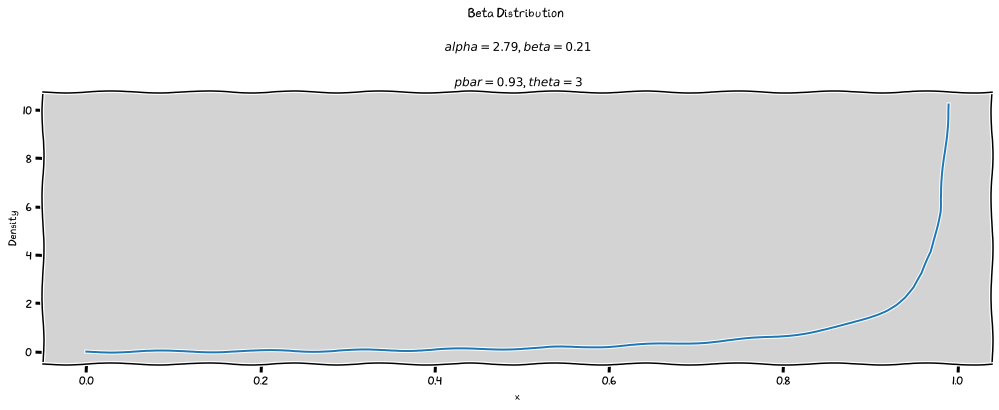

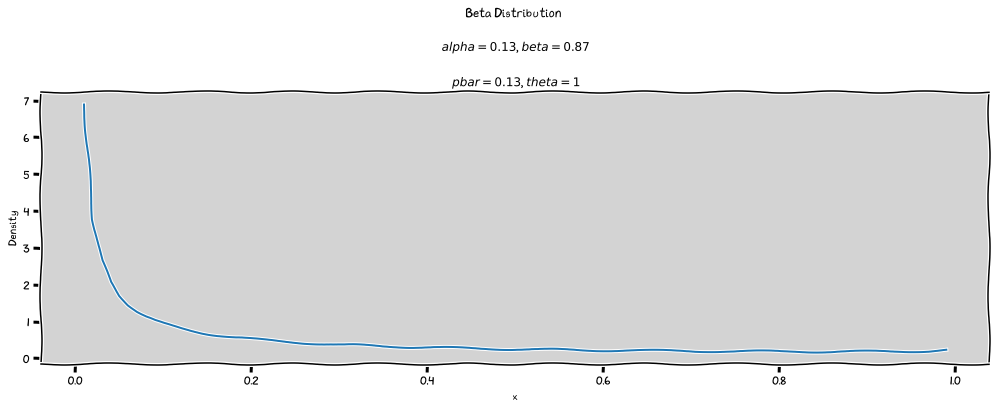

In [7]:
p_bar = 0.5
theta = 2
plot_beta(p_bar, theta)

# -----
p_bar = 0.5
theta = 1
plot_beta(p_bar, theta)

# -----
p_bar = 0.5
theta = 3
plot_beta(p_bar, theta)

# -----
p_bar = 0.93  # 0 < p < 1
theta = 3
plot_beta(p_bar, theta)

# -----
p_bar = 0.13  # 0 < p < 1
theta = 1
plot_beta(p_bar, theta)

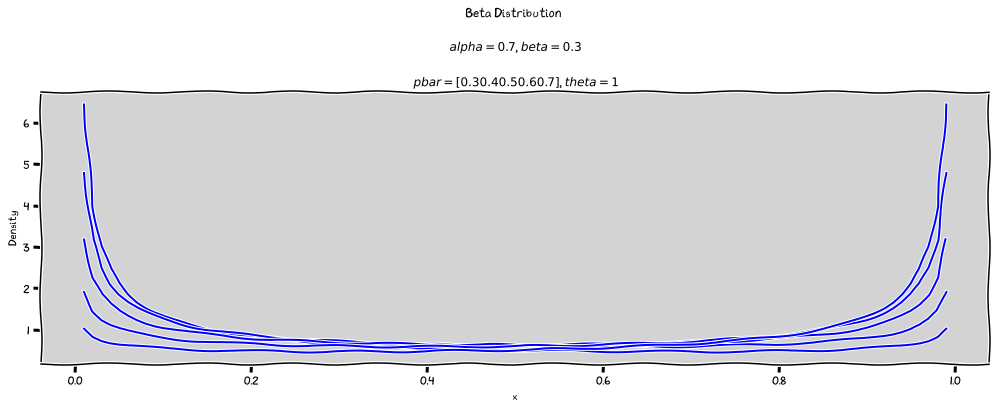

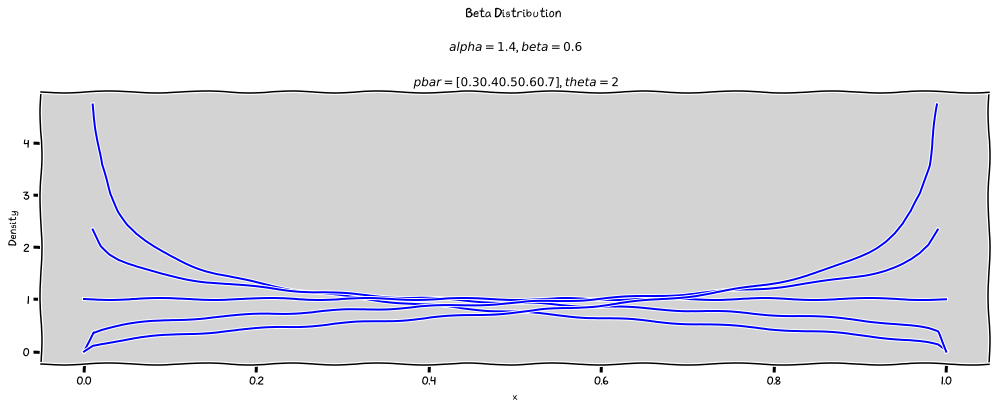

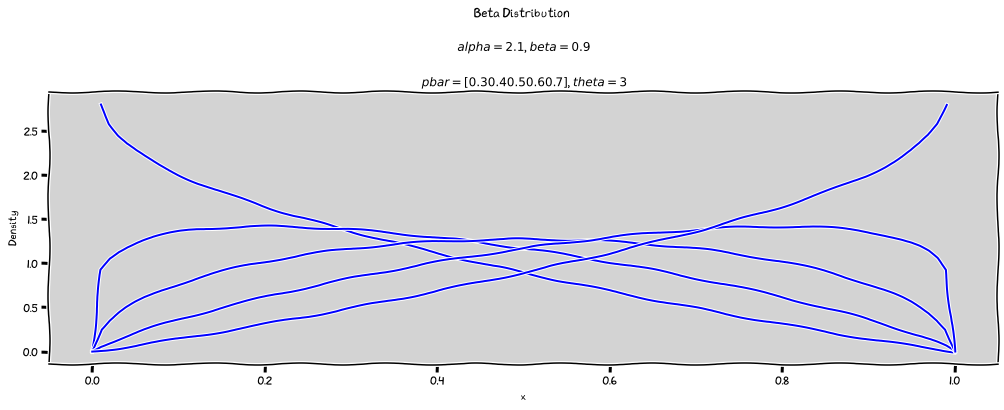

In [8]:

p_bar = np.arange(0.3, 0.8, 0.1)  # array([0.3, ..., 0.7])
theta = [1, 2, 3]

x = np.linspace(0, 1, num=100)



for t in theta:
    plt.figure(figsize=(17, 5))
    for p in p_bar:
        alpha = p * t
        beta = (1 - p) * t

        plt.plot(x, stats.beta.pdf(x, alpha, beta), c='blue')

        plt.title(f'Beta Distribution \n\n $alpha={round(alpha, 3)}$, $beta={round(beta, 3)}$ \n\n $pbar={p_bar}$, $theta={round(t, 3)}$')
        plt.ylabel('Density')
        plt.xlabel('x')
    plt.show()

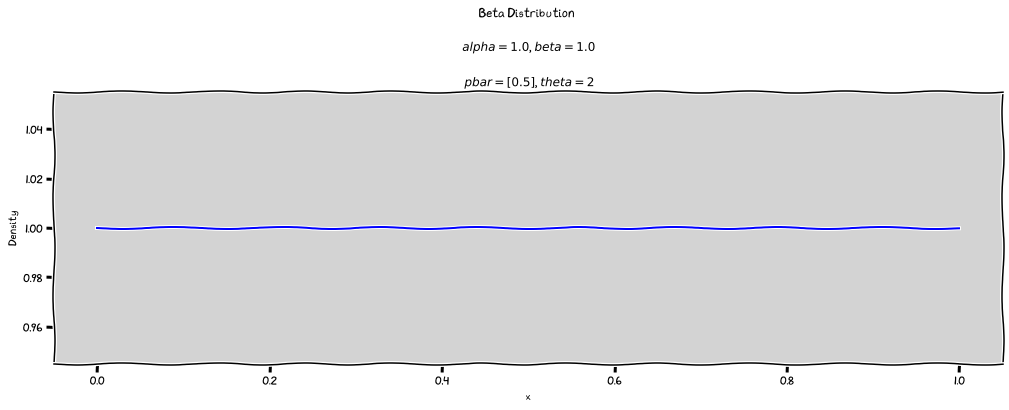

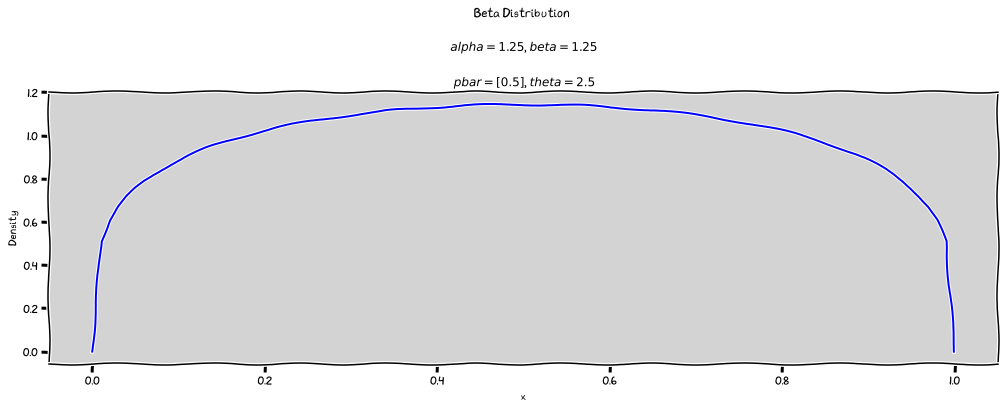

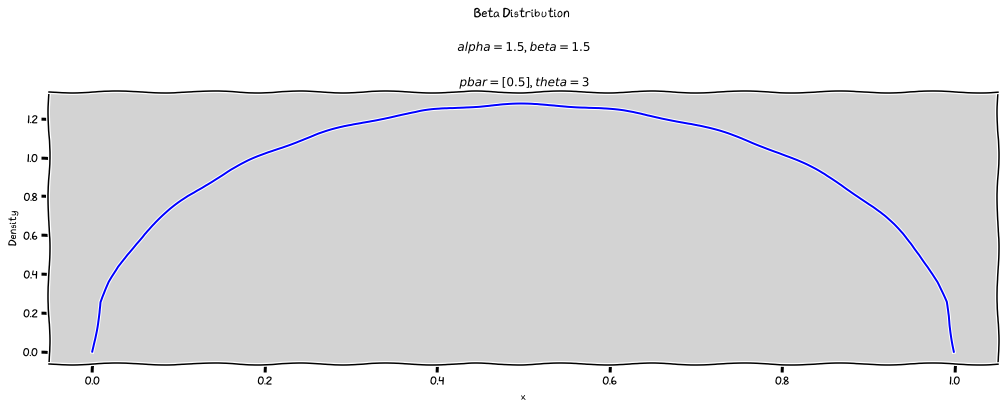

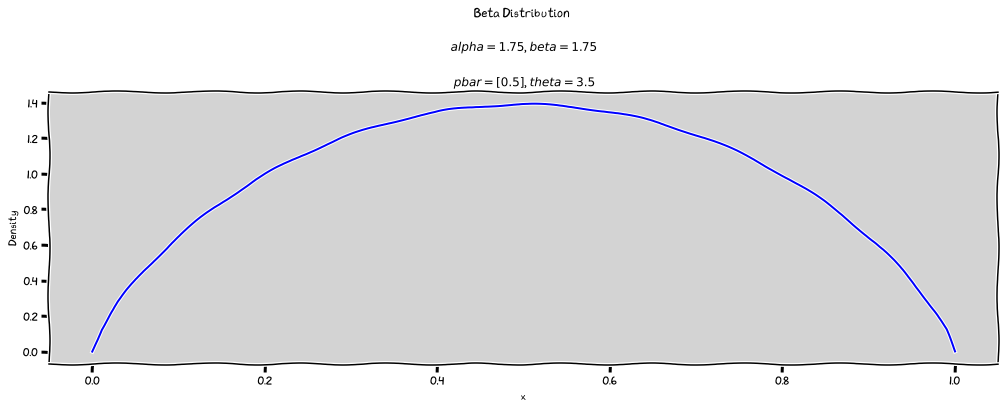

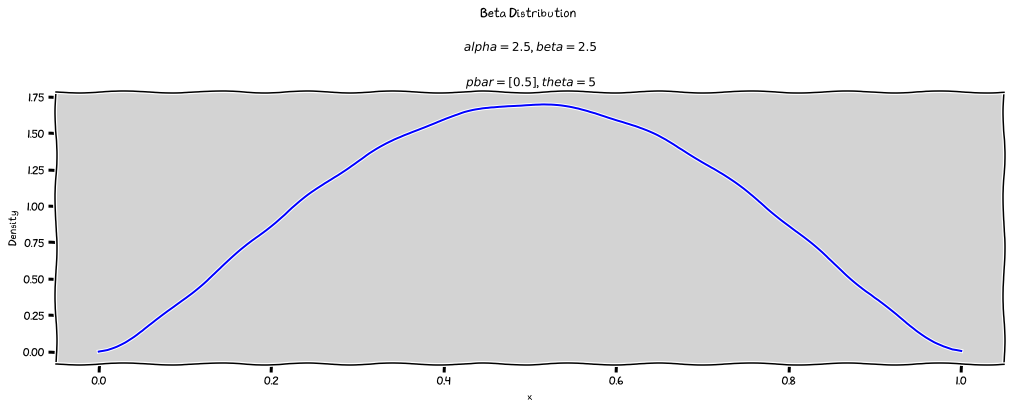

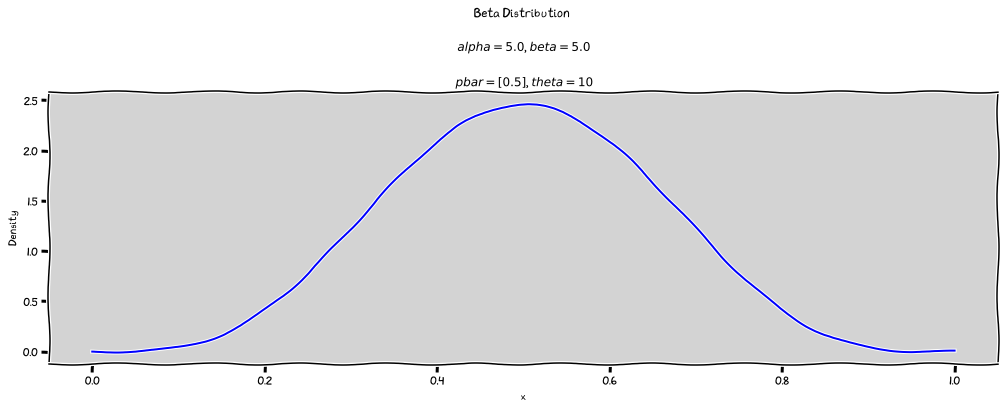

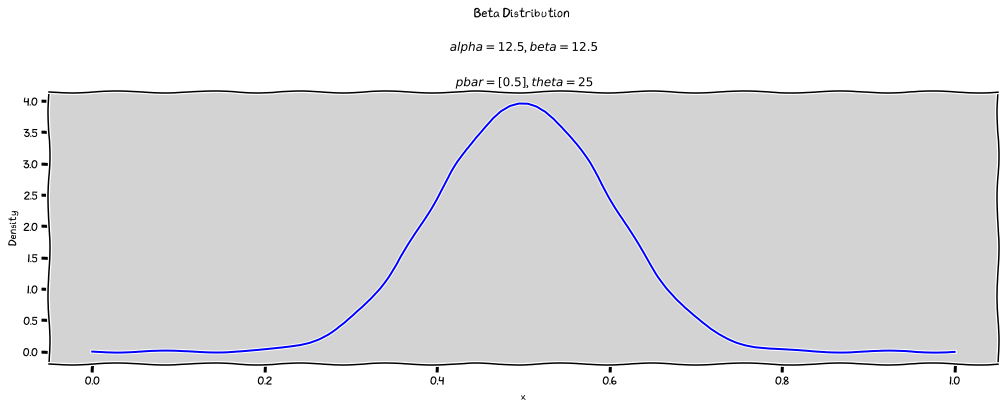

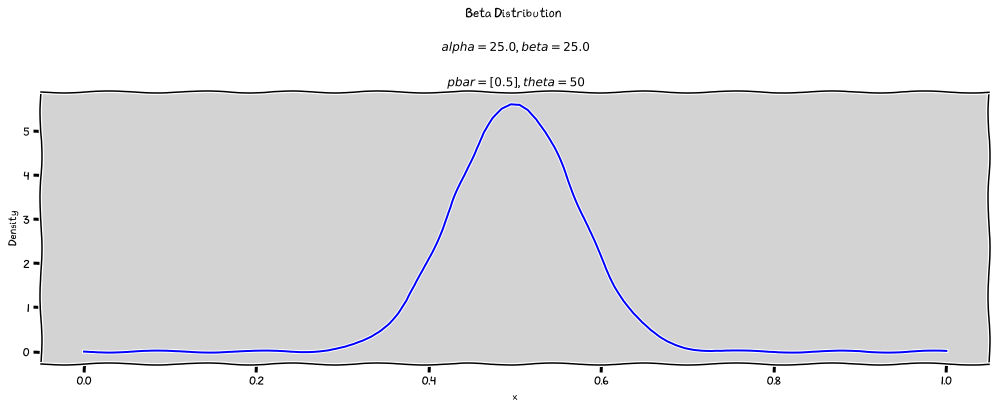

In [9]:
p_bar = [0.5]
theta = [2, 2.5, 3, 3.5, 5, 10, 25, 50]

x = np.linspace(0, 1, num=100)



for t in theta:
    plt.figure(figsize=(17, 5))
    for p in p_bar:
        alpha = p * t
        beta = (1 - p) * t

        plt.plot(x, stats.beta.pdf(x, alpha, beta), c='blue')

        plt.title(f'Beta Distribution \n\n $alpha={round(alpha, 3)}$, $beta={round(beta, 3)}$ \n\n $pbar={p_bar}$, $theta={round(t, 3)}$')
        plt.ylabel('Density')
        plt.xlabel('x')
    plt.show()

### R Code 12.2

#### The Beta-binomial model

$$ A_i \sim BetaBinomial(N_i, \bar{p}_i, \theta) $$ 

$$ logit(\bar{p}_i) = \alpha_{GID[i]} $$

$$ \alpha_j \sim Normal(0, 1.5) $$

$$ \theta = \phi + 2 $$

$$ \phi \sim Exponential(1) $$

Where:

- $A := $ `admit`
- $N := $ `applicantions`
- $GID[i] := $ `gid` is gender index,  $1$ to male $2$ to female

The BetaBinomial distribution in Stan has the parameters like most common Beta distribuiton. Then, the model above will be rewriter like:

$$ A_i \sim BetaBinomial(N_i, \alpha, \beta) $$ 

$$ \alpha = \bar{p}_i \times \theta $$

$$ \beta = (1 - \bar{p}_i) \times \theta $$

$$ logit(\bar{p}_i) = a_{GID[i]}  $$ 


$$ a_j \sim Normal(0, 1.5) $$

$$ \theta = \phi + 2 $$

$$ \phi \sim Exponential(1) $$

Where:

- $A := $ `admit`
- $N := $ `applicantions`
- $GID[i] := $ `gid` is gender index,  $1$ to male $2$ to female
- $\bar{p}_i := $ An average probability to gender type $i$
- $\theta := $ Shape of parameter, describe how spread out the distribution is.

Remember that binomial model for `UCBadmit` data, defined in 11.29, was written as follow:

$$ A_i \sim Binomial(N_i, p_i) $$

$$ logit(p_i) =  a_{GID[i]}$$

$$ a_j \sim Normal(0, 1.5) $$

In [10]:
df = pd.read_csv('./data/UCBadmit.csv', sep=';')
df['gid'] = [ 1 if gender == 'male' else 2 for gender in df['applicant.gender'] ]
df

,dept,applicant.gender,admit,reject,applications,gid
1,A,male,512,313,825,1
2,A,female,89,19,108,2
3,B,male,353,207,560,1
4,B,female,17,8,25,2
5,C,male,120,205,325,1
6,C,female,202,391,593,2
7,D,male,138,279,417,1
8,D,female,131,244,375,2
9,E,male,53,138,191,1
10,E,female,94,299,393,2


In [11]:
model = """
    functions {
        vector alpha_cast(vector pbar, real theta){
            return pbar * theta; 
        }
        
        vector beta_cast(vector pbar, real theta){
            return (1-pbar) * theta;
        }
    }
    
    data {
        int N;
        int qty_gid;
        array[N] int admit;
        array[N] int applications;
        array[N] int gid; 
    }
    
    parameters {
        vector[qty_gid] a;
        real<lower=0> phi;
    }
    
    transformed parameters {
        real<lower=2> theta;  // Need declared here to transform the parameter
        theta = phi + 2;
    }
    
    model {
        vector[N] pbar;
        
        a ~ normal(0, 1.5);
        phi ~ exponential(1);
        
        for (i in 1:N){
            pbar[i] = a[ gid[i] ];
            pbar[i] = inv_logit(pbar[i]);
        }
        
        admit ~ beta_binomial(applications, alpha_cast(pbar, theta), beta_cast(pbar, theta) );
    }
    
    generated quantities {
        real da;
        da = a[1] - a[2];
    }
    
"""

data_list = df[['applications', 'admit', 'gid']].to_dict('list')
data_list['N'] = len(df.admit)
data_list['qty_gid'] = len(df.gid.unique())
data_list

posteriori = stan.build(model, data=data_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 7.0s
Building: 

/home/rodolpho/.cache/httpstan/4.9.1/models/dxfzgnd7/model_dxfzgnd7.cpp: In constructor ‘model_dxfzgnd7_namespace::model_dxfzgnd7::model_dxfzgnd7(stan::io::var_context&, unsigned int, std::ostream*)’:
/home/rodolpho/.cache/httpstan/4.9.1/models/dxfzgnd7/model_dxfzgnd7.cpp:157:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  157 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~


Building: 14.6s
Building: 14.7s


In file included from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
            

Building: 14.8s
Building: 14.9s
Building: 15.0s
Building: 15.1s
Building: 15.2s
Building: 15.3s


/home/rodolpho/.cache/httpstan/4.9.1/models/dxfzgnd7/model_dxfzgnd7.cpp: In instantiation of ‘void model_dxfzgnd7_namespace::model_dxfzgnd7::transform_inits_impl(VecVar&, VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_vector_t<T_y>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/rodolpho/.cache/httpstan/4.9.1/models/dxfzgnd7/model_dxfzgnd7.cpp:534:69:   required from here
/home/rodolpho/.cache/httpstan/4.9.1/models/dxfzgnd7/model_dxfzgnd7.cpp:357:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  357 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
In file included from /home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/rodolpho/Projects/rethinking/RETHINKING/li

Building: 15.4s
Building: 15.5s
Building: 15.6s


/home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl_ab(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; T1 = stan::math::var_value<double>; T2 = stan::math::var_value<double>; T3 = stan::math::var_value<double>; T_z = stan::math::var_value<double>; ScalarT = stan::math::var_value<double>; TupleT = std::tuple<stan::math::var_value<double, void>, stan::math::var_value<double, void>, stan::math::var_value<double, void> >]’:
/home/rodolpho/Projects/rethinking/RETHINKING/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:205:78:   required from ‘TupleT stan::math::internal::grad_2F1_impl(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; bool calc_z = true; T1 = stan::math::var_va

Building: 15.7s
Building: 15.8s
Building: 15.9s
Building: 16.0s
Building: 16.1s
Building: 16.2s
Building: 16.3s
Building: 16.4s
Building: 16.5s
Building: 16.6s
Building: 16.7s
Building: 16.8s
Building: 16.9s
Building: 17.0s
Building: 17.2s
Building: 17.3s
Building: 17.4s
Building: 17.5s
Building: 17.6s
Building: 17.7s
Building: 17.8s
Building: 17.9s
Building: 18.0s
Building: 18.1s
Building: 18.2s
Building: 18.3s
Building: 18.4s
Building: 18.5s
Building: 18.6s
Building: 18.7s
Building: 18.8s
Building: 18.9s
Building: 19.0s
Building: 19.1s
Building: 19.2s
Building: 19.3s
Building: 19.4s
Building: 19.5s
Building: 19.6s
Building: 19.7s
Building: 19.8s
Building: 19.9s
Building: 20.0s
Building: 20.1s
Building: 20.2s
Building: 20.3s
Building: 20.4s
Building: 20.5s
Building: 20.6s
Building: 20.7s
Building: 20.9s
Building: 21.0s
Building: 21.1s
Building: 21.2s
Building: 21.3s
Building: 21.4s
Building: 21.5s
Building: 21.6s
Building: 21.7s
Building: 21.8s
Building: 21.9s
Building: 22.0s
Building

Building: 36.3s, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_binomial_lpmf: Second prior sample size parameter[1] is 0, but must be positive finite! (in '/tmp/httpstan_ub62w3hy/model_dxfzgnd7.stan', line 41, column 8 to column 94)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be re

In [12]:
model_12_1 = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
    observed_data=list(data_list.keys()),
    dims={
        'a': ['gender'],
    }
)

### R Code 12.3

In [13]:
az.summary(model_12_1, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.451,0.411,-1.145,0.157,0.008,0.006,2567.0,2263.0,1.0
a[1],-0.328,0.415,-0.987,0.335,0.008,0.006,2959.0,2432.0,1.0
phi,1.028,0.795,0.001,2.016,0.014,0.010,2365.0,1559.0,1.0
theta,3.028,0.795,2.001,4.016,0.014,0.010,2365.0,1559.0,1.0
da,-0.123,0.580,-1.072,0.761,0.011,0.010,2876.0,2735.0,1.0


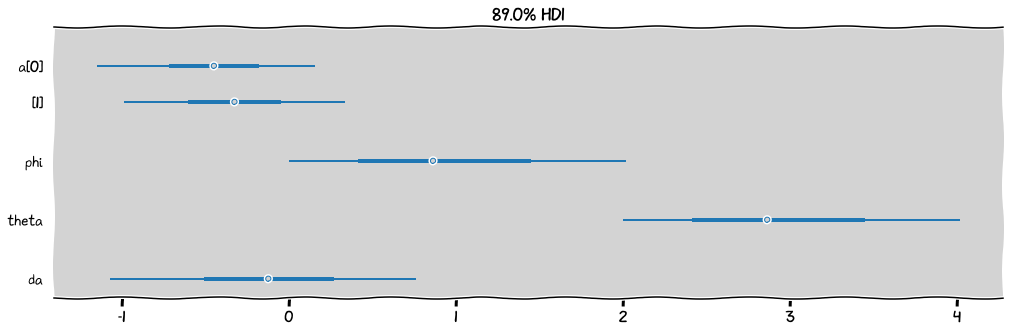

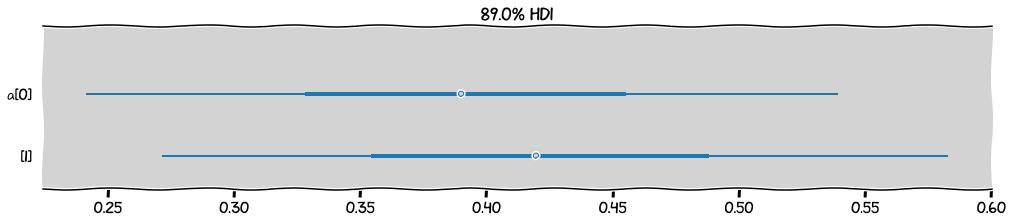

In [14]:
az.plot_forest(model_12_1, combined=True, figsize=(17, 5), hdi_prob=0.89)
az.plot_forest(model_12_1, var_names=['a'], combined=True, figsize=(17, 3), hdi_prob=0.89, transform=inv_logit)
plt.show()

### R Code 12.4

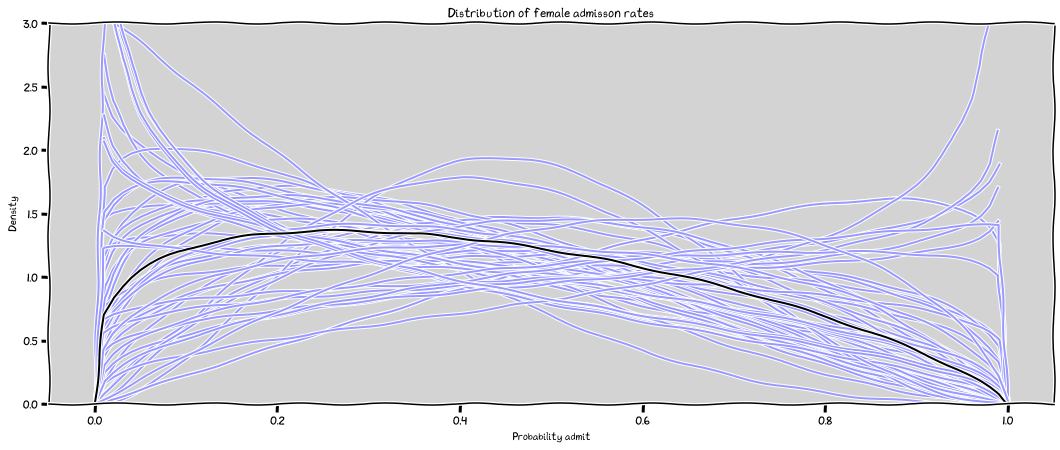

In [15]:
gid = 2  # female

p = inv_logit(model_12_1.posterior.a.sel(gender=1))
theta = model_12_1.posterior.theta

# Plot beta distribution posterior

alpha = p * theta  # Alpha = p * theta
beta = (1 - p) * theta  # beta = (1-p) * theta

plt.figure(figsize=(18, 7))

for i in range(50):
    plt.plot(x, stats.beta.pdf(x, alpha.values.flatten()[i], beta.values.flatten()[i]), c='blue', alpha=0.4)

plt.plot(x, stats.beta.pdf(x, alpha.values.mean(), beta.values.mean()), c='black', lw=2)

plt.ylim(0, 3)

plt.title(f'Distribution of female admisson rates')
plt.ylabel('Density')
plt.xlabel('Probability admit')

plt.show()

### R Code 12.5

In [16]:
p_m = inv_logit(model_12_1.posterior.a.sel(gender=0).values.flatten())  # Male
p_f = inv_logit(model_12_1.posterior.a.sel(gender=1).values.flatten())  # Female

theta = model_12_1.posterior.theta.values.flatten()

# Calculation of alpha and beta to Beta distribution
alpha_m = p_m*theta
beta_m = (1 - p_m)*theta

alpha_f = p_f*theta
beta_f = (1 - p_f)*theta

p_bar_m = np.random.beta(alpha_m, beta_m)
p_bar_f = np.random.beta(alpha_f, beta_f)

hdi_m = az.hdi(p_bar_m)
hdi_f = az.hdi(p_bar_f)

mean_m = np.mean(p_bar_m)
mean_f = np.mean(p_bar_f)


In [17]:
for i in range(10, 2):
    print(i)

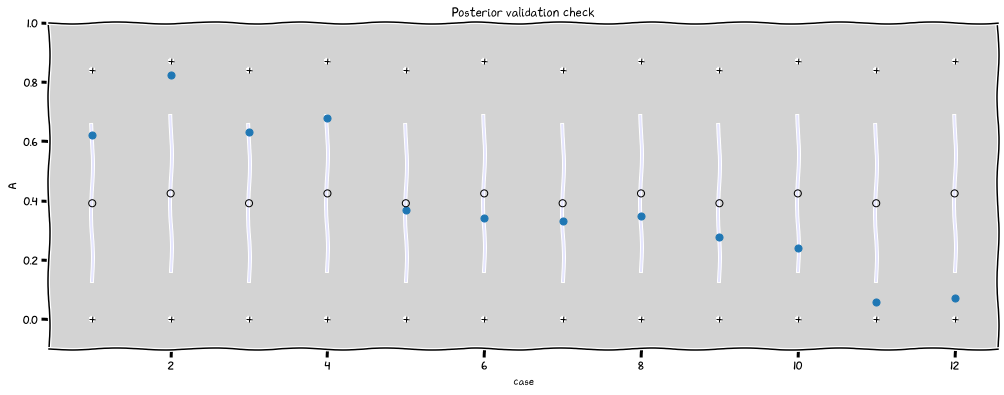

In [18]:
plt.figure(figsize=(17, 6))

for i in range(1, len(df), 2):
    # Male
    plt.plot([i, i], [mean_m - np.std(p_bar_m), np.std(p_bar_m) + mean_m ], c='blue', alpha=0.1)
    plt.plot(i, hdi_m[0], '+', c='k')
    plt.plot(i, hdi_m[1], '+', c='k')
    
    i = i + 1
    
    # Female
    plt.plot([i, i], [mean_f - np.std(p_bar_f), np.std(p_bar_f) + mean_f ], c='blue', alpha=0.1)
    plt.plot(i, hdi_f[0], '+', c='k')
    plt.plot(i, hdi_f[1], '+', c='k')

plt.scatter(range(1, len(df)+1), df.admit.values/df.applications.values, s=50, zorder=13)
plt.scatter(range(1, len(df)+1), [ mean_m if i == 1 else mean_f for i in df.gid ], facecolors='none', edgecolors='black', s=50, zorder=13)

plt.title('Posterior validation check')
plt.xlabel('case')
plt.ylabel('A')

plt.ylim(-0.1, 1)
plt.show()

### 12.1.2 Negative-binomial or Gamma-Poisson

$$ y_i \sim GammaPoisson(\lambda_i, \phi) $$

- The $\lambda$ parameter can be treated like the rate of an ordinary Poisson.
- The $\phi$ parameter must be positive and controls the variance.
- The variance of the Gamma-Poisson is $\lambda + \lambda^2 \over \phi$.
- The larges $\phi$ values mean is similar to a pure Poisson process. 

### R Code 12.6 - TODO

In [19]:
df = pd.read_csv('./data/Kline.csv', sep=';')
df['P'] = ( np.log(df.population) - np.mean(np.log(df.population)) ) / np.std(np.log(df.population))
df['contact_id'] = [2 if contact_i == 'high' else 1 for contact_i in df.contact ]
df

,culture,population,contact,total_tools,mean_TU,P,contact_id
0,Malekula,1100,low,13,3.2,-1.361332,1
1,Tikopia,1500,low,22,4.7,-1.147433,1
2,Santa Cruz,3600,low,24,4.0,-0.543664,1
3,Yap,4791,high,43,5.0,-0.346558,2
4,Lau Fiji,7400,high,33,5.0,-0.046737,2
5,Trobriand,8000,high,19,4.0,0.007029,2
6,Chuuk,9200,high,40,3.8,0.103416,2
7,Manus,13000,low,28,6.6,0.341861,1
8,Tonga,17500,high,55,5.4,0.546861,2
9,Hawaii,275000,low,71,6.6,2.446558,1


In [20]:
model = """
    data {
        int N;
        int qty_contact;
        array[N] int total_tools;
        array[N] int population;
        array[N] int contact_id;
    }
    
    parameters {
        array real[qty_contact] a;
        array real[qty_contact] b;
    }
    
    model {
        vector[N] lambda;
        real phi;
        
        phi ~ exponential(1);
        
        total_tools ~ neg_binomial(alpha, beta);
    }
"""

## 12.2 Zero-Inflated outcomes

### 12.2.1 Example: Zero-inflated Poisson

Coin flip, with probability $p$ that show "cask of wine" on one side and a quill on the other. 

- When monks is drinks, then none manuscript was be complete. 
- When hes are working, the manuscript are complete like the Poisson distribution on the average rate $\lambda$.  

The likelihood of a zero value $y$ is:

$$ Pr\{0 | p, \lambda \} = Pr\{drink|p\} + Pr\{work|p\} \times Pr\{0|\lambda\} $$
$$  = p + (1 + p) (\frac{\lambda^0 exp(-\lambda)}{0!}) $$
$$  = p + (1 + p) exp(-\lambda) $$

In above is just a math form to:

> The probability of observing a zero is the probability that the monks did drink OR ($+$) the probability that the monks worked AND ($\times$) failed to finish anything.

And the likelihood of a non-zero value $y$ is:

$$ Pr\{y | y > 0, p, \lambda \} = Pr\{dink | p \}(0) + Pr\{work | p\} \times Pr\{y | \lambda\} = (1-p) \frac{\lambda ^y exp(-y)}{y!} $$

> The probability that monks working, $1-p$, and finish $y$ manuscripts. Since the drinking monks, $p$, never finish any manuscript.

The ZIPoisson, with parameters $p$ (probability of a zeros) and $\lambda$ (rate mean of Poisson) to describe the shape. 

The zero-inflated Poisson regression is that form:

$$ y_i \sim ZIPoisson(p_i, \lambda_i) $$

$$ logit(p_i) = \alpha_p + \beta_p x_i $$

$$ log(\lambda_i) =  \alpha_\lambda + \beta_\lambda x_i $$

### R Code 12.7 

In [174]:
prob_drink = 0.2  # 20% of days
rate_work = 1  # average 1 manuscript per day

# Samples one year of production
N = 365

# Simulate days monks drink
drink = np.random.binomial(n=1, p=prob_drink, size=N)
print('Drink day == 1')
print(drink)

# Simulate manuscript completed
y = (1 - drink) * np.random.poisson(lam=rate_work, size=N)
print('\n Work day')
print(y)

Drink day == 1
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 1
 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1
 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 0
 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1]

 Work day
[0 0 1 4 3 1 4 1 1 2 3 2 2 1 1 0 2 1 0 0 1 0 0 0 2 0 1 0 1 2 2 0 2 2 0 0 0
 2 0 1 0 2 0 0 0 0 1 0 1 0 0 2 0 2 2 1 2 1 2 0 0 1 3 0 0 1 2 0 0 4 3 1 1 0
 0 1 1 0 1 1 1 0 0 0 1 0 4 2 0 1 0 5 0 1 0 1 0 1 0 1 2 1 0 2 0 0 0 0 1 1 0
 2 0 3 2

### R Code 12.8

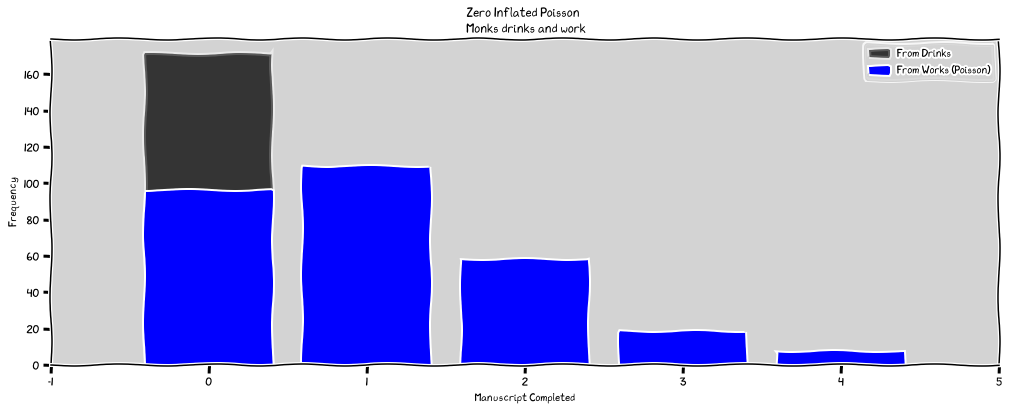

In [176]:
plt.figure(figsize=(17, 6))

zeros_drink = np.sum(drink)
zeros_work = np.sum((y == 0) * (drink == 0))  # and
zeros_total = np.sum( y==0 )

plt.bar(0, zeros_total, color='black', alpha=0.5, label='From Drinks')
plt.bar(0, zeros_work, color='blue', label='From Works (Poisson)')

for i in range(1, max(y)):
    plt.bar(i, np.sum(y == i), color='blue')

plt.xlim(-1, max(y))

plt.title('Zero Inflated Poisson \n Monks drinks and work')
plt.xlabel('Manuscript Completed')
plt.ylabel('Frequency')

plt.legend()
plt.show()

### R Code 12.9

The zero-inflated Poisson model:

$$ y_i \sim ZIPoisson(p_i, \lambda_i) $$

$$ logit(p_i) = a_p $$

$$ log(\lambda_i) =  a_\lambda $$

$$ a_p \sim normal(-1.5, 1) $$

$$ a_l \sim normal(1, 0.5) $$

##### Zero Inflation

Consider the following example for zero-inflated Poisson distributions. 

- There is a probability $\theta$ of observing a zero, and 
- a probability  $1 - \theta$ of observing a count with a $Poisson(\lambda)$ distribution 

(now $\theta$ is being used for mixing proportions because $\lambda$ is the traditional notation for a Poisson mean parameter). Given the probability $\theta$ and the intensity $\lambda$, the distribution for $y_n$ can be written as:

$$
y_n \sim 
\begin{cases}
 0 & \quad\text{with probability } \theta, \text{ and}\\
 \textsf{Poisson}(y_n \mid \lambda) & \quad\text{with probability } 1-\theta.
\end{cases}
$$

Stan does not support conditional sampling statements (with $\sim$) conditional on some parameter, and we need to consider the corresponding likelihood:

$$
p(y_n \mid \theta,\lambda)
=
\begin{cases}
\theta + (1 - \theta) \times \textsf{Poisson}(0 \mid \lambda) & \quad\text{if } y_n = 0, \text{ and}\\
(1-\theta) \times \textsf{Poisson}(y_n \mid \lambda) &\quad\text{if } y_n > 0.
\end{cases}
$$

The log likelihood can be implemented directly in Stan (with `target +=`) as follows.


The mixture can be implemented as:

```{stanc3}
for (n in 1:N) {
  target += log_mix(lambda,
                    normal_lpdf(y[n] | mu[1], sigma[1]),
                    normal_lpdf(y[n] | mu[2], sigma[2])) 
};
```

or equivalently,

```{stanc3}
for (n in 1:N) {
  target += log_sum_exp(log(lambda)
                          + normal_lpdf(y[n] | mu[1], sigma[1]),
                        log1m(lambda)
                          + normal_lpdf(y[n] | mu[2], sigma[2]));
```

This definition assumes that each observation $y_n$ may have arisen from either of the mixture components. The density is:

$$ 
p\left(y \mid \lambda, \mu, \sigma\right)
= \prod_{n=1}^N \big(\lambda \times \textsf{normal}\left(y_n \mid \mu_1, \sigma_1 \right)
                 + (1 - \lambda) \times \textsf{normal}\left(y_n \mid \mu_2, \sigma_2 \right)\big)
$$


----

`real log_mix(real theta, real lp1, real lp2)`

Return the log mixture of the log densities $lp1$ and $lp2$ with mixing proportion theta, defined by:

$$
\begin{eqnarray*}
\mathrm{log\_mix}(\theta, \lambda_1, \lambda_2) & = & \log \!\left(
\theta \exp(\lambda_1) + \left( 1 - \theta \right) \exp(\lambda_2)
\right) \\[3pt] & = & \mathrm{log\_sum\_exp}\!\left(\log(\theta) +
\lambda_1, \ \log(1 - \theta) + \lambda_2\right). \end{eqnarray*}
$$

ref: [Stan Docs](https://mc-stan.org/docs/functions-reference/composed-functions.html)

----

- In example below, used this:

$$ \theta == p $$

Refs:
- [Zero-Inflated and hurdle model - (Stan Docs)](https://mc-stan.org/docs/stan-users-guide/zero-inflated.html)
- [Vectorizing Mixtures - (Stan Docs)](https://mc-stan.org/docs/stan-users-guide/vectorizing-mixtures.html)
- [Diane Lambert (papers bell labs)](http://plan9.bell-labs.co/who/dl.old/pub.html): Zero-Inflated Poisson Regression, With an Application to Defects in Manufacturing, Diane Lambert, Technometrics, 34 (1992), pp. 1-14.

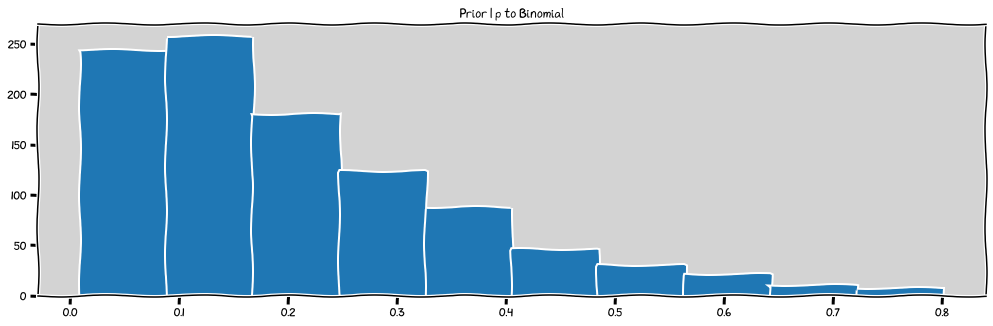

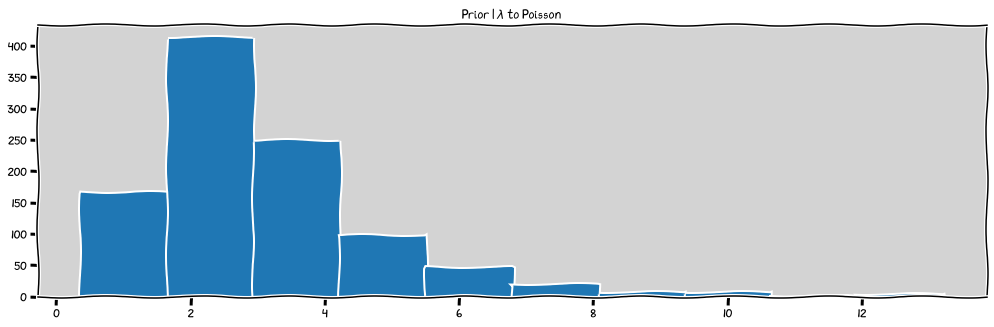

In [197]:
# Prioris
ap = np.random.normal(-1.5, 1, 1000)
al = np.random.normal(1, 0.5, 1000)

p = inv_logit(ap)
lam = np.exp(al)

plt.figure(figsize=(17, 5))
plt.hist(p)
plt.title('Prior | p to Binomial')
plt.show()

plt.figure(figsize=(17, 5))
plt.hist(lam)
plt.title('Prior | $\lambda$ to Poisson')
plt.show()

In [189]:
model = """
    data {
        int<lower=0> N;
        array[N] int<lower=0> y;
    }
    
    parameters {
        real al;
        real ap;
    }
    
    model {
        real p;
        real lambda;
        
        // Prior
        ap ~ normal(-1.5, 1);
        al ~ normal(1, 0.5);
        
        // Link functions
        p = inv_logit(ap);
        lambda = exp(al);
        
        // Likelihood
        for (i in 1:N){
            if (y[i] == 0) target += log_mix(p, 0, poisson_lpmf(0 | lambda));
            if (y[i] > 0)  target += log1m(p) + poisson_lpmf(y[i] | lambda);
        }
    }
"""

dat_list = {
    'N': len(y),
    'y': y,
}

posteriori = stan.build(model, data=dat_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:   5% (400/8000)
Sampling:  14% (1100/8000)
Sampling:  39% (3100/8000)
Sampling:  64% (5100/8000)
Sampling:  84% (6700/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 8.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.87 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
  Adjust your expectations accordingly!


In [190]:
model_12_3 = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
    observed_data=['y']
)

In [191]:
az.summary(model_12_3, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
al,0.080,0.082,-0.046,0.218,0.002,0.002,1263.0,1499.0,1.0
ap,-1.502,0.398,-2.059,-0.928,0.012,0.009,1273.0,1163.0,1.0


### R Code 12.10

In [192]:
print('Results: ')
print(' - p estimated: ', np.round(np.mean(inv_logit(model_12_3.posterior.ap.values.flatten())), 2), ' \t\t p original: ', prob_drink)
print(' - lambda estimated: ', np.round(np.mean(np.exp(model_12_3.posterior.al.values.flatten())), 2), ' \t estimated original: ', rate_work)

Results: 
 - p estimated:  0.19  		 p original:  0.2
 - lambda estimated:  1.09  	 estimated original:  1


### R Code 12.11

In [194]:
# This code is the same code that R Code 12.09
# In this book is stan version